In [ ]:
import csv
#from io import open
def load_data():
    data = []

    label = ['image_id','unixtime','rawtime','title','total_votes','reddit_id','number_of_upvotes',\
    'subreddit','number_of_downvotes','localtime','score','number_of_comments','username',\
    'undefined1','undefined2', 'undefined3']

    with open('submissions.csv') as csvfile:
        csvReader = csv.reader(csvfile)
        for row in csvReader:
            if row[0] == '#image_id':
                continue
            d = {}
            for i,elem in enumerate(row):
                d[label[i]] = elem
            data.append(d)

    return data


In [ ]:
#image.py
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import os
IMAGE_DIR = 'image_feature'
PIC_DIR = 'pic'

def load_overall_stat():
    with open(os.path.join(IMAGE_DIR,'/content/overall_stat.json'),'r') as fp:
        overall_stat = json.load(fp)
    return overall_stat

def load_each_image_stat():
    with open(os.path.join(IMAGE_DIR,'/content/each_image_stat.json'),'r') as fp:
        each_image_stat = json.load(fp)
    return each_image_stat

def gen_feature(target):
    """
    @param target: target is the prediction feature. It should be either 'number_of_comments' or 'total_votes'
    """
    image_vec = {}
    each_image_stat = load_each_image_stat()
    overall_stat = load_overall_stat()

    avg_number_of_upvotes = overall_stat.get('avg_number_of_upvotes')
    std_number_of_upvotes = overall_stat.get('std_number_of_upvotes')
    avg_number_of_comments = overall_stat.get('avg_number_of_comments')
    std_number_of_comments = overall_stat.get('std_number_of_comments')

    for image_id,value in each_image_stat.items():
        if target == 'number_of_comments':
            image_vec[image_id] = [1, float(value.get('avg_number_of_upvotes')-avg_number_of_upvotes)/std_number_of_upvotes] # normalize
        elif target == 'total_votes':
            image_vec[image_id] = [1, float(value.get('avg_number_of_comments')-avg_number_of_comments)/std_number_of_comments]
        else:
            print ('{0} is undefined.'.format(target))
            break

    with open(os.path.join(IMAGE_DIR,'/content/image_vec_number_of_comments.json'),'w') as f:
        json.dump(image_vec,f)

def _image():
    data = load_data()
    data = data[:int(len(data)/3)]
    each_image_stat = {}

    features = ['number_of_upvotes','number_of_downvotes','number_of_comments']
    for record in data:
        image_id = record.get('image_id')
        if image_id not in each_image_stat:
            each_image_stat[image_id] = defaultdict(float)
        for feature in features:
            each_image_stat[image_id]['avg_'+feature] += float(record.get(feature))
        each_image_stat[image_id]['num_of_posts'] += 1
    
    for image_id,stat in each_image_stat.items():
        for feature in features:
            each_image_stat[image_id]['avg_'+feature] /= each_image_stat[image_id]['num_of_posts']
        each_image_stat[image_id] = dict(each_image_stat[image_id])

    number_of_upvotes_list = [int(record.get('number_of_upvotes')) for record in data]
    number_of_downvotes_list = [int(record.get('number_of_downvotes')) for record in data]
    number_of_comments_list = [int(record.get('number_of_comments')) for record in data]

    overall_stat = {
        'avg_number_of_upvotes': np.mean(number_of_upvotes_list),
        'avg_number_of_downvotes': np.mean(number_of_downvotes_list),
        'avg_number_of_comments': np.mean(number_of_comments_list),
        'std_number_of_upvotes': np.std(number_of_upvotes_list),
        'std_number_of_downvotes': np.std(number_of_downvotes_list),
        'std_number_of_comments': np.std(number_of_comments_list)
    }

    with open(os.path.join(IMAGE_DIR,'/content/each_image_stat.json'),'w') as fp:
        json.dump(dict(each_image_stat),fp)
    with open(os.path.join(IMAGE_DIR,'/content/overall_stat.json'),'w') as fp:
        json.dump(overall_stat,fp)



if __name__ == '__main__':
    _image()
    gen_feature("number_of_comments")
    gen_feature("total_votes")



In [ ]:
#user_name
from collections import defaultdict
import json
import numpy as np
import matplotlib.pyplot as plt
import os
USER_DIR = 'user_feature'
PIC_DIR = 'pics'
def _load_each_user_profile():
    with open(os.path.join(USER_DIR,'/content/each_user_profile.json'),'r') as f:
        each_user_profile = json.load(f)
    return each_user_profile

def _load_user_stat():
    with open(os.path.join(USER_DIR,'user_stat.json'),'r') as f:
        user_stat = json.load(f)
    return user_stat

def gen_feature(target):
    """
    @param target: target is the prediction feature. It should be either 'number_of_comments' or 'total_votes'
    """
    user_vec = {}
    user_stat = _load_user_stat()
    user_profile = _load_each_user_profile()
    total_avg_comments = user_stat['avg_comments']
    total_std_comments = user_stat['std_comments']
    total_avg_votes = user_stat['avg_votes']
    total_std_votes = user_stat['std_votes']
    
    for user in user_profile:
        user_name = user.get('username')
        avg_comments = user.get('avg_comments')
        # avg_downvotes = user.get('avg_downvotes')
        # avg_upvotes = user.get('avg_upvotes')
        avg_votes = user.get('avg_votes')
        if target == "number_of_comments":        
            user_vec[user_name] = [1,float(avg_votes-total_avg_votes)/total_std_votes]
        elif target == 'total_votes': # target is number of votes
            user_vec[user_name] = [1,float(avg_comments-total_avg_comments)/total_std_comments]
        else:
            print('{0} is undefined.'.format(target))
            break

    with open(os.path.join(USER_DIR,'user_vec_'+target+'.json'),'w') as f:
        json.dump(user_vec,f)

def _username():
    data = load_data()
    data = data[:len(data)/3]
    user_post_num = defaultdict(int)
    user_down_vote = defaultdict(int)
    user_up_vote = defaultdict(int)
    user_vote = defaultdict(int)
    user_comment_num = defaultdict(int)

    for record in data:
        user_name = record.get('username')
        user_post_num[user_name] += 1
        user_comment_num[user_name] += int(record.get('number_of_comments'))
        user_down_vote[user_name] += int(record.get('number_of_downvotes'))
        user_up_vote[user_name] += int(record.get('number_of_upvotes'))
        user_vote[user_name] += int(record.get('total_votes'))

    post_num_list = sorted(user_post_num.items(),key=lambda item:item[1], reverse=True)
    # max_post = max(post_num_list, key=lambda item:item[1])
    # min_post = min(post_num_list, key=lambda item:item[1])
    avg_post_num = np.mean(user_post_num.values())
    median_post_num = np.median(user_post_num.values())
    std_post_num = np.std(user_post_num.values())

    avg_votes = np.mean(user_vote.values())
    std_votes = np.std(user_vote.values())

    avg_comments = np.mean(user_comment_num.values())
    std_comments = np.std(user_comment_num.values())

    def user_profile(user_name):
        profile = {
            'username':user_name,
            'num_of_post':user_post_num[user_name],
            'avg_comments':float(user_comment_num[user_name])/user_post_num[user_name],
            'avg_downvotes':float(user_down_vote[user_name])/user_post_num[user_name],
            'avg_upvotes':float(user_up_vote[user_name])/user_post_num[user_name],
            'avg_votes':float(user_vote[user_name])/user_post_num[user_name],
        }
        return profile

    each_user_profile = [user_profile(user) for user in user_post_num.keys()]

    result = {
        'top_10':[user_profile(ele[0]) for ele in post_num_list[:10]],
        'bottom_10':[user_profile(ele[0]) for ele in post_num_list[-10:]],
        'avg_post_num':avg_post_num,
        'median_post_num':median_post_num,
        'avg_votes':avg_votes,
        'std_votes':std_votes,
        'avg_comments':avg_comments,
        'std_comments':std_comments
    }

    with open(os.path.join(USER_DIR,'each_user_profile.json'),'w') as f:
        json.dump(each_user_profile,f)

    with open(os.path.join(USER_DIR,'user_stat.json'),'w') as f:
        json.dump(result,f)

    with open(os.path.join(USER_DIR,'all_user_post_num.json'),'w') as f:
        json.dump(dict(user_post_num),f)

def _evaluate():
    each_user_profile = _load_each_user_profile()
    post_list = []
    comment_list = []
    votes_list = []
    for user in each_user_profile:
        post_list.append(user.get('num_of_post'))
        comment_list.append(user.get('avg_comments'))
        votes_list.append(user.get('avg_votes'))
    
    result = {"post_num_vs_votes":np.corrcoef(post_list,votes_list).tolist(),
    "post_num_vs_comments": np.corrcoef(post_list,comment_list).tolist(),
    "votes_vs_comments":np.corrcoef(votes_list,comment_list).tolist()
    }
    with open(os.path.join(USER_DIR,'/content/correlation_matrix.json'),'w') as fp:
        json.dump(result,fp)

    #plt.scatter(x=post_list,y=comment_list,alpha=0.5,color='r',marker='+')
    plt.scatter(x=comment_list,y=votes_list,alpha=0.5,color='g',marker='o')
    #plt.xlabel("number of the posts from a user")
    plt.ylabel("average number of the votes the user obtained")
    plt.xlabel("average number of the comments the user obtained")
    plt.title("votes VS comments")
    plt.savefig(os.path.join(PIC_DIR,'/content/comments_vs_votes.png'),format='png')

if __name__ == '__main__':
    #_username()
    _evaluate()
    #gen_feature("number_of_comments")
    #gen_feature("total_votes")


    

In [ ]:
from collections import defaultdict
import json
import numpy 
import matplotlib.pyplot as plt
import os
from math import exp
from math import log

def f(theta, X, y, lam):
  theta = numpy.matrix(theta).T
  X = numpy.matrix(X)
  y = numpy.matrix(y).T
  diff = X*theta - y
  diffSq = diff.T*diff
  diffSqReg = diffSq / len(X) + lam*(theta.T*theta)
  #print "offset =", diffSqReg.flatten().tolist()
  return diffSqReg.flatten().tolist()[0]

def fprime(theta, X, y, lam):
  theta = numpy.matrix(theta).T
  X = numpy.matrix(X)
  y = numpy.matrix(y).T
  diff = X*theta - y
  res = 2*X.T*diff / len(X) + 2*lam*theta
  #print "gradient =", numpy.array(res.flatten().tolist()[0])
  return numpy.array(res.flatten().tolist()[0])

def inner(X,theta):
	res=0.0
	for i in range(len(X)):
		res+=X[i]*theta[i]
	return res

def ComputeMSE(X,y,theta):
	N=len(X)
	MSE=0.0
	for i in range(N):
		MSE = MSE+(y[i]-inner(X[i],theta))*(y[i]-inner(X[i],theta))
	return MSE/float(N)

data=load_data()
unixtime=[]
upvotes=[]
downvotes=[]
comments=[]
score=[]
features=[]
votes=[]
user=[]
image=[]
isfunny=[]
isgif=[]
localtime=[]
title=[]
length=len(data)
time1=[]
v1=[]
time10005=[]
v2=[]
time1001=[]
v3=[]
subreddit=defaultdict(int)
subcount=defaultdict(int)
community=[]

userdic=defaultdict(int)
usercoutn=defaultdict(int)
for record in data:
	unixtime.append(float(record.get('unixtime')))
	upvotes.append(float(record.get('number_of_upvotes')))
	downvotes.append(float(record.get('number_of_downvotes')))
	comments.append(float(record.get('number_of_comments')))
	score.append(float(record.get('score')))
	votes.append(float(record.get('total_votes')))
	user.append(record.get('username'))
	image.append(record.get('image_id'))
	community.append(record.get('subreddit'))
	userdic[record.get('username')]+=float(record.get('number_of_comments'))
	usercoutn[record.get('username')]+=1

	if record.get('subreddit')=='funny':
		isfunny.append(1)
	else:
		isfunny.append(0)
	if record.get('subreddit')=='gif':
		isgif.append(1)
	else:
		isgif.append(0)
	t=record.get('rawtime')
	te=t.split('-')
	localtime.append(int(te[1]))
	subreddit[record.get('subreddit')]+=float(record.get('number_of_comments'))
	subcount[record.get('subreddit')]+=1
#print max(comments)
#print max(comments)/len(comments)
Mintime=min(unixtime)

usertemp=[]
for use in userdic:
	usertemp.append((usercoutn[use],userdic[use]/usercoutn[use],use))
usertemp.sort()
usertemp.reverse()
#print usertemp[:10]
temp=[]
for sub in subreddit:
	temp.append((subreddit[sub]/subcount[sub],sub))

temp.sort()
temp.reverse()
phase=[]
t1=[]
t2=[]
t3=[]
t4=[]
t5=[]
t6=[]
t7=[]
t8=[]
t9=[]
t10=[]
t11=[]
for (ave,sub) in temp:
	if ave>2000:
		t1.append(sub)
	elif ave>900:
		t2.append(sub)
	elif ave>700:
		t3.append(sub)
	elif ave>400:
		t4.append(sub)
	elif ave>300:
		t5.append(sub)
	elif ave>180:
		t6.append(sub)
	elif ave>140:
		t7.append(sub)
	elif ave>100:
		t8.append(sub)
	elif ave>50:
		t9.append(sub)
	elif ave>20:
		t10.append(sub)
	else:
		t11.append(sub)

phase.append(t1)
phase.append(t2)
phase.append(t3)
phase.append(t4)
phase.append(t5)
phase.append(t6)
phase.append(t7)
phase.append(t8)
phase.append(t9)
phase.append(t10)
phase.append(t11)

features=[]
for i in range(length):
	temp=[]
	for j in range(11):
		temp.append(0)
	for j in range(11):
		if community[i] in phase[j]:
			temp[j]=1
	features.append(temp)

phase=[]
t1=[]
t2=[]
t3=[]
t4=[]
t5=[]
t6=[]
t7=[]
t8=[]
t9=[]
t10=[]
t11=[]

for (count,ave,use) in usertemp:
	if ave>1000:
		t1.append(use)
	elif ave>500:
		t2.append(use)
	elif ave>300:
		t3.append(use)
	elif ave>200:
		t4.append(use)
	elif ave>100:
		t5.append(use)
	elif ave>70:
		t6.append(use)
	elif ave>35:
		t7.append(use)
	elif ave>20:
		t8.append(use)
	elif ave>10:
		t9.append(use)
	elif ave>5:
		t10.append(use)
	else:
		t11.append(use)

phase.append(t1)
phase.append(t2)
phase.append(t3)
phase.append(t4)
phase.append(t5)
phase.append(t6)
phase.append(t7)
phase.append(t8)
phase.append(t9)
phase.append(t10)
phase.append(t11)

for i in range(length):
	temp=[]
	for j in range(11):
		temp.append(0)
	for j in range(11):
		if user[i] in phase[j]:
			temp[j]=1
	features[i]+=temp

#plt.plot(comments,score,color='r',label='score')
#plt.plot(comments,votes,color='b',label='votes')

#plt.show()
#time1.sort()
#time10005.sort()
#print time1
#print time10005

#f=open('title/kmean_cluster_10_feature_vector.txt')
pre=localtime[0]
index=1

#f=open('title/svd_tfidf_100.txt')

index=1
'''
for line in f.readlines():
	topic=line.split()
	temp=[1]
	for t in topic:
		temp.append(float(t))
	features.append(temp)
'''
'''
with open('title/F_20_1.json') as f:
	topic=json.load(f)
for t in topic:
	temp=[1]
	#for o in t:
	#	temp.append(float(o))
	features.append(temp)
with open('title/F_20_2.json') as f:
	topic=json.load(f)
for t in topic:
	temp=[1]
	#for o in t:
	#	temp.append(float(o))
	features.append(temp)
with open('title/F_20_3.json') as f:
	topic=json.load(f)
for t in topic:
	temp=[1]
	#for o in t:
	#	temp.append(float(o))
	features.append(temp)
with open('title/F_20_4.json') as f:
	topic=json.load(f)
for t in topic:
	temp=[1]
	#for o in t:
	#	temp.append(float(o))
	features.append(temp)
with open('title/F_20_5.json') as f:
	topic=json.load(f)
for t in topic:
	temp=[1]
	#for o in t:
	#	temp.append(float(o))
	features.append(temp)
'''
with open ('/content/user_vec_number_of_comments.json') as f:
	user_comments_dic=json.load(f)

with open ('/content/user_vec_total_votes.json') as f:
	user_votes_dic=json.load(f)

with open ('/content/image_vec_number_of_comments.json') as f:
	image_comments_dic=json.load(f)

with open ('/content/image_vec_total_votes.json') as f:
	image_votes_dic=json.load(f)

with open ('/content/F_new.json') as f:
	new=json.load(f)
pretime=unixtime[0]
preid=image[0]

for i in range(length):
	u=user[i]
	im=image[i]
	e=[0,0]
	if image[i]==preid and comments[i]<20:
		features[i].append(-log((float(pretime))/unixtime[i]))
	else:
		preid=image[i]
		pretime=unixtime[i]
		features[i].append(-log((float(pretime)/unixtime[i])))
	features[i]+=new[i]
	features[i].append(1)


	#if user_comments_dic.has_key(u):
	#	temp=user_comments_dic[u]
	#	features[i].append(float(temp[0]))
	#	features[i].append(float(temp[1]))
	#else:
	#	features[i].append(0)
	#	features[i].append(0)
	#if image_votes_dic.has_key(im):
	#	temp=image_votes_dic[im]
	#	features[i].append(float(temp[0]))
	#	features[i].append(float(temp[1]))
	#else:
	#	features[i].append(0)
	
	#features[i].append(isfunny[i])
	#features[i].append(isgif[i])
	#if localtime[i]==pre:
	#	features[i].append(1.0/(index**2))
	#	index+=1
	#else:
	#	pre=localtime[i]
	#	index=1
	#	features[i].append(1.0/(index**2))
	#if localtime[i]==pre and index<7:
	#	features[i].append((7-index))
	#	index+=1
	#elif localtime[i]==pre and index>=7:
	#	features[i].append(0)
	#	index+=1
	#else:
	#	pre=localtime[i]
	#	index=0
	#	features[i].append((7-index))

	#features[i].append(unixtime[i]-Mintime)
	#features[i].append(float(comments[i]))




#theta,residuals,rank,s = numpy.linalg.lstsq(features[:length/3], comments[:length/3])
#y=[]
#for i in range(length/3:2*length/3):
#	y.append(inner(features[i]))
#Mse=ComputeMSE(features[:length/3],comments[:length/3],theta)
#print Mse
#Mse=ComputeMSE(features[length/3:2*length/3],comments[length/3:2*length/3],theta)
#print Mse
#Mse=ComputeMSE(features[2*length/3:length],comments[2*length/3:length],theta)
#print Mse
#print features[:10]
#print votes[:10]

#print inner(features[0],theta)

#y=[inner(features[i],theta) for i in range(length/3)]
#print y[:10]
#print votes[:10]
a = int(length/3)
length = (3*a)
from sklearn.neural_network import MLPRegressor
MLP_model = MLPRegressor(hidden_layer_sizes=(60,40,20),activation='tanh')
trained_MLP = MLP_model.fit(features[:int(length/3)], comments[:int(length/3)])

# test set evaluation
predicted = trained_MLP.predict(features[int(length/3):2*int(length/3)])
print(predicted[:10])

MSE = 0.0
for i in range(len(predicted)):
    MSE += (predicted[i] - comments[i+int(length/3)])**2

MSE = MSE/len(predicted)

print(MSE)


# test set evaluation
predicted = trained_MLP.predict(features[:int(length/3)])

MSE = 0.0
for i in range(len(predicted)):
    MSE += (predicted[i] - comments[i])**2

MSE = MSE/len(predicted)

print(MSE)


predicted = trained_MLP.predict(features[2*int(length/3):length])


MSE = 0.0
for i in range(len(predicted)):
    MSE += (predicted[i] - comments[i+2*int(length/3)])**2

MSE = MSE/len(predicted)

print(MSE)

#Mse=ComputeMSE(features[length/3:2*length/3],comments[length/3:2*length/3],theta)



'''
user_comments_dic=open('user_feature/user_vec_number_of_comments.json')
user_votes_dic=json.load('user_feature/user_vec_total_votes.json')

image_comments_dic=json.load('image_feature/image_vec_number_of_comments.json')
image_votes_dic=json.load('image_feature/image_vec_total_votes.json')


'''


In [ ]:
# linear model.py
import csv

data = []

label = ['image_id','unixtime','rawtime','title','total_votes','reddit_id','number_of_upvotes',\
'subreddit','number_of_downvotes','localtime','score','number_of_comments','username',\
'undefined1','undefined2', 'undefined3']

with open('submissions.csv', newline='', encoding='utf-8') as csvfile:
    csvReader = csv.reader(csvfile)
    for row in csvReader:
        if row[0] == '#image_id':
            continue
        d = {}
        for i,elem in enumerate(row):
            d[label[i]] = elem
        data.append(d)

# word count (title)
from collections import defaultdict
import string
wordCount = defaultdict(int)
punctuation = set(string.punctuation)

for d in data:
    r = ''.join([c for c in d['title'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

print(len(wordCount))

from nltk.corpus import stopwords
for w in stopwords.words("english"):
    if w in wordCount:
        wordCount.pop(w)

print(len(wordCount))
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

# output top 50 frequent words in title
f = open('/content/top50_words_in_title.txt','w')

for x in range(50):
    f.write(counts[x][1] + ': ' + str(counts[x][0]) + '\n')

f.close()

# take top 1000 words to be our targets
words = [x[1] for x in counts[:1000]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['title'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat

X = [feature(d) for d in data]
y_upvotes = [d['number_of_upvotes'] for d in data]
y_downvotes = [d['number_of_downvotes'] for d in data]
y_score = [d['score'] for d in data]
data = []

from sklearn import linear_model
clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(X[:5000], y_upvotes[:5000]) # when using all set of data, MEMORY ERROR!!!
theta = clf.coef_

#store word-theta pairs
f = open('theta.txt','w')

for x in range(len(theta)):
    try:
        f.write(words[x] + ': ' + str(theta[x]) + '\n')
    except Exception as e:
        pass

f.close()

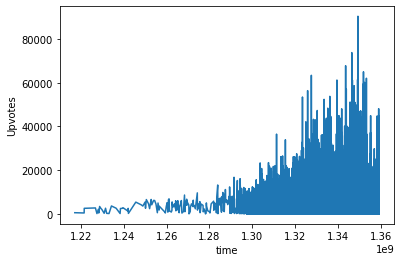

In [ ]:
from load_data import *
from collections import defaultdict
import json
import numpy 
import matplotlib.pyplot as plt
import os
from math import log

data=load_data()
unixtime=[]
upvotes=[]
downvotes=[]
comments=[]
score=[]
features=[]
votes=[]
user=[]
image=[]
isfunny=[]
isgif=[]
localtime=[]
length=len(data)
title=[]
time1=[]
v1=[]
time10005=[]
v2=[]
time1001=[]
v3=[]
community=defaultdict(list)
index=0
for record in data:

	unixtime.append(float(record.get('unixtime')))
	upvotes.append(float(record.get('number_of_upvotes')))
	downvotes.append(float(record.get('number_of_downvotes')))
	comments.append(float(record.get('number_of_comments')))
	score.append(float(record.get('score')))
	votes.append(float(record.get('total_votes')))
	user.append(record.get('username'))
	image.append(record.get('image_id'))
	title.append(record.get('title'))

	community[record.get('subreddit')].append(index)

	if record.get('subreddit')=='funny':
		isfunny.append(1)
	else:
		isfunny.append(0)
	if record.get('subreddit')=='gif':
		isgif.append(1)
	else:
		isgif.append(0)
	t=record.get('rawtime')
	te=t.split('-')
	temp=[]
	temp.append(int(te[0]))
	temp.append(int(te[1]))
	day=te[2].split('T')

	localtime.append([int(te[0]),int(te[1]),int(day[0])])

year=2012

day=3 #5,6,13

test=[]
userdetect=[]
timedetect=[]
noone=[]
imagedetect=defaultdict(int)
length=len(data)
timedic=defaultdict(int)
yeartime1=defaultdict(int)
yeartime2=defaultdict(int)
yeartime3=defaultdict(int)

for i in range(length):
	test.append((upvotes[i],title[i],user[i],localtime[i],isfunny[i],isgif[i]))
	userdetect.append((upvotes[i],user[i]))
	if localtime[i][0]==2010:
		yeartime1[localtime[i][1]]+=upvotes[i]
	if localtime[i][0]==2011:
		yeartime2[localtime[i][1]]+=upvotes[i]
	if localtime[i][0]==2012:
		yeartime3[localtime[i][1]]+=upvotes[i]
	if user[i]=='':
		noone.append(upvotes[i])
	timedic[(localtime[i][0],localtime[i][1],localtime[i][2])]+=1
	imagedetect[image[i]]+=1
	timedetect.append((unixtime[i],upvotes[i]))
timedetect.sort()
x=[]
y=[]
for (ti,up) in timedetect:
	x.append(ti)
	y.append(up)

plt.plot(x,y)
plt.xlabel("time")
plt.ylabel("Upvotes")

plt.show()

'''
bar_width = 0.5
temp=[]
for t in yeartime1:
	temp.append((t,yeartime1[t]))
temp.sort()
index = numpy.arange(12)
up=[]
for (_,u) in temp:
	up.append(u)
p1=plt.subplot(311)
p1.bar(index,up,bar_width,color='b',label="2010")

p1.set_ylabel('upvotes')
plt.xticks(index + bar_width / 2, ('1', '2', '3', '4', '5','6','7','8','9','10','11','12'))
temp=[]
for t in yeartime2:
	temp.append((t,yeartime2[t]))
temp.sort()
index = numpy.arange(12)
up=[]
for (_,u) in temp:
	up.append(u)
p1=plt.subplot(312)
p1.bar(index,up,bar_width,color='b',label="2011")


plt.xticks(index + bar_width / 2, ('1', '2', '3', '4', '5','6','7','8','9','10','11','12'))
temp=[]
for t in yeartime3:
	temp.append((t,yeartime3[t]))
temp.sort()
index = numpy.arange(12)
up=[]
for (_,u) in temp:
	up.append(u)
p1=plt.subplot(313)
p1.bar(index,up,bar_width,color='b',label="2012")
p1.set_xlabel('month')

plt.xticks(index + bar_width / 2, ('1', '2', '3', '4', '5','6','7','8','9','10','11','12'))


plt.show()
'''
'''
temp=[]
for t in timedic:
	temp.append((timedic[t],t))
temp.sort()
temp.reverse()

print temp[:5]
timedetect.sort()
userdetect.sort()
userdetect.reverse()

time1.sort()
time2.sort()
time3.sort()
time4.sort()
time5.sort()

x=[]
y=[]
for (un,up) in time1:
	x.append(un)
	y.append(up)

usercount=defaultdict(list)
for (up,us) in userdetect:
	if up>=1000:
		usercount[us].append(up)
#print usercount

#print len(timedetect)
x=[]
y=[]
for (t,u) in time1:
	x.append(t)
	y.append(u)
p1=plt.subplot(511)
p1.plot(x,y,color='b')
p1.set_xlabel('unixtime')
p1.set_ylabel('upvotes')

x=[]
y=[]
for (t,u) in time2:
	x.append(t)
	y.append(u)
p1=plt.subplot(512)
p1.plot(x,y,color='b')
p1.set_xlabel('unixtime')
p1.set_ylabel('upvotes')

x=[]
y=[]
for (t,u) in time3:
	x.append(t)
	y.append(u)
p1=plt.subplot(513)
p1.plot(x,y,color='b')
p1.set_xlabel('unixtime')
p1.set_ylabel('upvotes')

x=[]
y=[]
for (t,u) in time4:
	x.append(t)
	y.append(u)
p1=plt.subplot(514)
p1.plot(x,y,color='b')
p1.set_xlabel('unixtime')
p1.set_ylabel('upvotes')


x=[]
y=[]
for (t,u) in time5:
	x.append(t)
	y.append(u)
p1=plt.subplot(515)
p1.plot(x,y,color='b')
p1.set_xlabel('unixtime')
p1.set_ylabel('upvotes')

plt.show()
'''
'''
iimage=[]
for i in imagedetect:
	iimage.append((imagedetect[i],i))
iimage.sort()
iimage.reverse()
'''
'''
#print iimage[:5]
im=['6037','5919','174','6219','996']
tempx=[]
tempy=[]
tempz=[]
temp=[]
for j in range(length):
	if image[j]=='6037':
		temp.append((unixtime[j],comments[j],upvotes[j]))
temp.sort()
for (time,co,up) in temp:
	tempx.append(time)
	tempy.append(co)
	tempz.append(up)
p1=plt.subplot(511)
#p1.plot(tempx,tempy,label='comments',color='r')
p1.plot(tempx,tempz,label='upvotes',color='b')
p1.set_xlabel('unixtime')
p1.set_ylabel('upvotes')

tempx=[]
tempy=[]
tempz=[]
temp=[]
for j in range(length):
	if image[j]=='5919':
		temp.append((unixtime[j],comments[j],upvotes[j]))
temp.sort()
for (time,co,up) in temp:
	tempx.append(time)
	tempy.append(co)
	tempz.append(up)
p1=plt.subplot(512)
#p1.plot(tempx,tempy,label='comments',color='r')
p1.plot(tempx,tempz,label='upvotes',color='b')
p1.set_xlabel('unixtime')
p1.set_ylabel('upvotes')

tempx=[]
tempy=[]
tempz=[]
temp=[]
for j in range(length):
	if image[j]=='174':
		temp.append((unixtime[j],comments[j],upvotes[j]))
temp.sort()
for (time,co,up) in temp:
	tempx.append(time)
	tempy.append(co)
	tempz.append(up)
p1=plt.subplot(513)
#p1.plot(tempx,tempy,label='comments',color='r')
p1.plot(tempx,tempz,label='upvotes',color='b')
p1.set_xlabel('unixtime')
p1.set_ylabel('upvotes')

tempx=[]
tempy=[]
tempz=[]
temp=[]
for j in range(length):
	if image[j]=='6219':
		temp.append((unixtime[j],comments[j],upvotes[j]))
temp.sort()
for (time,co,up) in temp:
	tempx.append(time)
	tempy.append(co)
	tempz.append(up)
p1=plt.subplot(514)
#p1.plot(tempx,tempy,label='comments',color='r')
p1.plot(tempx,tempz,label='upvotes',color='b')
p1.set_xlabel('unixtime')
p1.set_ylabel('upvotes')

tempx=[]
tempy=[]
tempz=[]
temp=[]
for j in range(length):
	if image[j]=='996':
		temp.append((unixtime[j],comments[j],upvotes[j]))
temp.sort()
for (time,co,up) in temp:
	tempx.append(time)
	tempy.append(co)
	tempz.append(up)
p1=plt.subplot(515)
#p1.plot(tempx,tempy,label='comments',color='r')
p1.plot(tempx,tempz,label='upvotes',color='b')
p1.set_xlabel('unixtime')
p1.set_ylabel('upvotes')

plt.show()
'''
#print len(noone)
noone.sort()
noone.reverse()
#print noone



#test.sort()
#test.reverse()
#print test[:20]

#plt.show()
#f=plt.figure()
#plt.plot(x,y)
#plt.show()

In [ ]:
import sys
sys.path = ['', '/Users/jiazhuoqin/anaconda/lib/python27.zip', '/Users/jiazhuoqin/anaconda/lib/python2.7', '/Users/jiazhuoqin/anaconda/lib/python2.7/plat-darwin', '/Users/jiazhuoqin/anaconda/lib/python2.7/plat-mac', '/Users/jiazhuoqin/anaconda/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/jiazhuoqin/anaconda/lib/python2.7/lib-tk', '/Users/jiazhuoqin/anaconda/lib/python2.7/lib-old', '/Users/jiazhuoqin/anaconda/lib/python2.7/lib-dynload', '/Users/jiazhuoqin/anaconda/lib/python2.7/site-packages', '/Users/jiazhuoqin/anaconda/lib/python2.7/site-packages/Sphinx-1.6.3-py2.7.egg', '/Users/jiazhuoqin/anaconda/lib/python2.7/site-packages/aeosa']
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from sklearn import linear_model
#reload(sys) 
#sys.setdefaultencoding('utf8') 

# read data

In [ ]:
import pandas as pd
df = pd.read_csv('submissions.csv', encoding='utf-8', names = ['image_id','unixtime','rawtime','title','total_votes','reddit_id','number_of_upvotes',\
'subreddit','number_of_downvotes','localtime','score','number_of_comments','username',\
'undefined1','undefined2', 'undefined3']

)

/Users/jiazhuoqin/anaconda/envs/gl-env/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,1,4,6,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df = df.iloc[1:, :]

In [ ]:
titles = df['title'].tolist()
subreddit = df['subreddit'].tolist()
score = df['score'].tolist()

# get x and subreddit

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()
    
# list for tokenized documents in loop
texts = []

# loop through document list
for i in titles:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
  
    # stem tokens
    try:
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    except:
        print i
    # add tokens to list
    texts.append(stemmed_tokens)  #data 1 texts

In [ ]:
from collections import defaultdict
count = defaultdict(int)

for document in texts:
    for stem in document:
        count[stem] += 1
        
for letter in list('abcdedfgijklmnopqrstuvwxyz'):
    if letter in count:
        count.pop(letter)
        
words_cut = [(item[1] , item[0]) for item in count.items() if item[1] > 10]
words_sort = sorted(words_cut,reverse = True)
len_words = len(words_sort) # data 3 len of frequent words
print len(words_sort)

words_cut_sorted = [item[1] for item in words_sort]  # data 2 frequent words(stems)

4577


# use frequent stem to predict score (influence of stem)

In [ ]:
X_stem = []
for document in texts:
    temp = [1] + [0] * len_words
    for item in document:
        if item in words_cut_sorted:
            temp[words_cut_sorted.index(item) + 1] += 1
    X_stem.append(temp)

In [ ]:
#score has been got
Y_score = []
for item in score:
    Y_score.append(int(item))
print len(score)
print score[1]

132307
23


In [ ]:
clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(X_stem, Y_score) # when using all set of data, MEMORY ERROR!!!
theta = clf.coef_

In [ ]:
theta = theta.tolist()

In [ ]:
#store word-theta pairs
f = open('theta.txt','w')
max1 = max(theta)
min1 = min(theta)
max_index = theta.index(max1)
min_index = theta.index(min1)

f.write('the max theta is ' + words_cut_sorted[max_index] + ': ' + str(theta[max_index]) + '\n')
f.write('the min theta is ' + words_cut_sorted[min_index] + ': ' + str(theta[min_index]) + '\n')
for x in range(len(theta)):
    try:
        f.write(words_cut_sorted[x] + ': ' + str(theta[x]) + '\n')
    except Exception as e:
        pass

f.close()

# check result's R^2 and mse

In [ ]:
mse = 0

for i in range(132307):
    temp = 0
    for j in range(len_words + 1):
        temp += X_stem[i][j] * theta[j]
    mse += (Y_score[i] - temp) ** 2
mse = mse *1.0 / 132307
print mse
print clf.score(X_stem, Y_score, sample_weight=None)

217584.005219
0.0600356785449


# check influence

In [ ]:
print len(theta)
print len(words_cut_sorted)
print theta[:100]
print words_cut_sorted.index(u'dog')

900
899
[ 243.79549109    9.33716888  -36.6641914   -27.60457848  -19.00734995
   -4.72793876  -19.45460056   -6.32457961  -26.9228977     7.90470621
    6.85685518  -15.94852879   41.29603368  -14.97874384   -4.06019382
  -17.92337457  -17.83340635   -0.67876939   26.55750396   47.89755628
  -31.45924949  -19.7875087    11.72490203   -6.11687528   34.80934735
  -22.04414761   -3.60983512    7.06458181   13.46278737  -17.61563304
  -11.22274791    1.12022952    4.01644004   20.06954561  -93.04873768
  -13.02918789  -21.32921893    9.13645911   23.09404815  -15.4077732
   58.89583205   17.90348274  -35.53761995   -1.91065149   24.52194482
   -9.27750016  -14.55793172    3.34561524    7.33391673  -29.6799541
   17.41247944   -0.97292458   -1.45907993  -48.89434959   22.44322598
  -33.07361742  -15.55227514  -26.96164552   29.35984779  -50.90504698
    9.24708458    7.89510548   24.8929253   -73.22655481   16.38576638
   15.83901878  -16.24412451  -89.77765077  -50.02427683  148.60101173
